In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pymc3 as pm

In [48]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) /n

    return x, y

In [49]:
def frequentist_mean(sample):
    
    """ given a sample, use Frequentist Inference to return the 95 % confidence interval for the mean as a tuple"""
    
    # compute summary statistics of the sample
    observed_mean = np.mean(sample)
    observed_std = np.std(sample, ddof=1)
    
    # compute standard error
    standard_err = observed_std/np.sqrt(len(sample))
    
    # compute critical value for 95% confidence
    crit_val = norm.ppf(0.975)
    
    # compute Margin of Error
    marg_err = crit_val * standard_err
    
    # compute 95% confidence interval
    int_min = observed_mean - marg_err
    int_max = observed_mean + marg_err
    
    return (int_min, int_max)

In [50]:
def percentile_p(arr, p):
    """return a tuple of the lower and upper bounds of a p_% confindence interval"""
    ends = 100 - p
    left = ends/2
    right = 100 - left
    return np.percentile(arr, [left, right])

In [51]:
def bootstrap_replicate_1d(data, func):
    """Draw a single bootstrap replicate"""
    return func(np.random.choice(data, size=len(data)))

In [52]:
def draw_bs_reps(data, func, size=1):
    """Draw many bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [53]:
def bootstrap_mean(sample):
    
    """ given a sample, use Bootstrap Statistics to return the distribution and the 95 % confidence interval for the mean as a tuple"""
    
    # generate 10,000 bootstrap replicates
    N_reps = 10000
    bs_replicates = draw_bs_reps(sample, np.mean, N_reps)
    
    # compute standard error of the mean 
    sem = np.std(sample) / np.sqrt(len(sample))
    
    # compute extremes of 95 percentile
    int_min, int_max = percentile_p(bs_replicates, 95)
    
    conf_min, conf_max = percentile_p(bs_replicates, 95)
    conf_range = bs_replicates[(bs_replicates >= conf_min) & (bs_replicates <= conf_max)]
    
    
    # plot distribution of bootstrap replicates
    _ , bins, _ = plt.hist(bs_replicates, bins=50, density=True, alpha=0.5)
    _ = plt.hist(conf_range, bins=bins, density=True, alpha=1, color='b')
    _ = plt.xlabel('mean')
    _ = plt.ylabel('PDF')


    _ = plt.axvline(conf_min, color='w', linestyle='-', linewidth=2.5)
    _ = plt.axvline(conf_max, color='w', linestyle='-', linewidth=2.5)
    _ = plt.axvline(np.mean(bs_replicates), color='w', linestyle=':')
    _ = plt.axvline(observed_us_mean, color='r', alpha=0.5, linestyle=':')

    _ = plt.title('95% Confidence Interval of the Mean')
    print(np.mean(bs_replicates).round(3), observed_us_mean.round(3))
    plt.show()
    
    return (bs_replicates, int_min, int_max)
    

In [54]:
def bayesian_mean(sample):
    
    """ given a sample, use Bayesian Inference to return the distribution and the 95 % confidence interval for the mean as a tuple"""
    
    # compute sample size
    n_sample = len(sample)
    
    # estimate initial parameters
    alpha_est = np.mean(sample)**2 / np.var(sample)
    beta_est = np.var(sample) / np.mean(sample)
    
    # estimate rate
    rate_est = 1/beta_est
    
    # create PyMC3 Model
    
    with pm.Model() as Model:
        
        # set number of draws for the model
        N_draws = 10000
        
        # use exponential prior for alpha
        alpha_ = pm.Exponential('alpha_', 1/alpha_est)

        # use exponential prior for rate (1 / beta)
        rate_ = pm.Exponential('rate_', 1/rate_est)

        # create gamma distribution
        us_sample_gam_dist = pm.Gamma('us_sample_gam_dist', alpha=alpha_, beta=rate_, observed=us_sample)

        # perfrom 10000 draws
        trace = pm.sample(N_draws)
        
        # calculate the 95% credible interval for alpha & beta
        alpha_ci = percentile_p(trace['alpha_'], 95)
        beta_ci = percentile_p(1/trace['rate_'], 95)
        int_min , int_max = alpha_ci
        
    # plot posterior values of alpha & beta
    _ = pm.plots.plot_posterior(data=trace['alpha_'], color='k')
    _ = plt.hist(trace['alpha_'], bins=30, color='blue', alpha=0.35, density=True)
    _ = plt.axvline(int_min, color='red', linestyle='-.')
    _ = plt.axvline(int_max, color='blue', linestyle='-.')
    _ = plt.axvline(np.mean(trace['alpha_']), color='w', linestyle=':')
    _ = plt.legend(['density', '94% credible interval', '2.5 percentile','97.5 percentile','','','alpha'])
    _ = plt.title('alpha: distribution of posterior values')
    _ = plt.ylabel('pdf')
    _ = plt.xlabel('alpha')

    plt.show()
    
    return (trace['alpha_'], int_min, int_max)
    

In [57]:
def explore_bins(dist):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    _ = plt.hist(dist, bins=10)
    _ = plt.title('10 bins')
    plt.subplot(1,3,2)
    _ = plt.hist(dist, bins=20)
    _ = plt.title('20 bins')
    plt.subplot(1,3,3)
    _ = plt.hist(dist, bins=30)
    _ = plt.title('30 bins')
    

**Identifying the mean cost of living in the US**

In [56]:
# read cost of living data from file
cost_living = pd.read_csv('clean_data/cost_of_living.csv')

# isolate US cities
us_sample = cost_living[cost_living.country == ' United States'].cost_of_living
us_sample.head()

420    93.19
421    71.87
422    59.80
423    64.84
424    60.31
Name: cost_of_living, dtype: float64

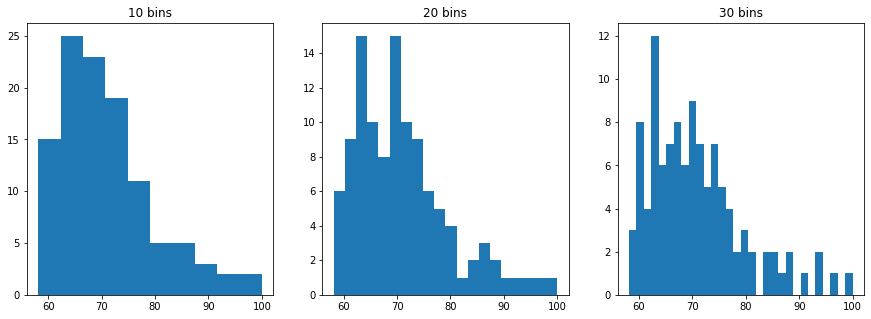

In [58]:
# examine distribution and appropriate bin sizes
explore_bins(us_sample)

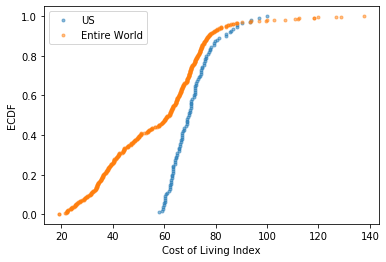

In [59]:
# compute ECDF for US data
x_us, y_us = ecdf(data4.cost_of_living)

# compute ECDF for world data
x_world, y_world = ecdf(cost_living.cost_of_living)


# plot ECDFs
_ = plt.plot(x_us, y_us, marker='.', linestyle='none', alpha=0.5)
_ = plt.plot(x_world, y_world, marker='.', linestyle='none', alpha=0.5)
_ = plt.legend(['US', 'Entire World'])
_ = plt.xlabel('Cost of Living Index')
_ = plt.ylabel('ECDF')

plt.show()


After observing various renditions of the distributions, we can assume they are bimodal and not normal. The distributions appear to have exponential characteristics, so Bayesian inference will work best for determining the credible interval of the population mean.

Using Frequentists Inference, the 95% confidence interval for the mean can be computed as follows:

In [68]:
# compute 95% confidence interval for the mean using Frequentist Inference
freq_min, freq_max = frequentist_mean(us_sample)

70.894 70.906


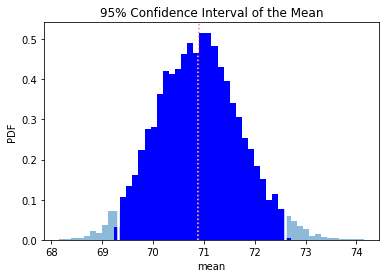

In [63]:
# compute 95% confidence interval for the mean using Bootstrap Statistics
boot_dist, boot_min, boot_max = bootstrap_mean(us_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_, alpha_]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:32<00:00, 227.20draws/s]
The acceptance probability does not match the target. It is 0.8900569160319555, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


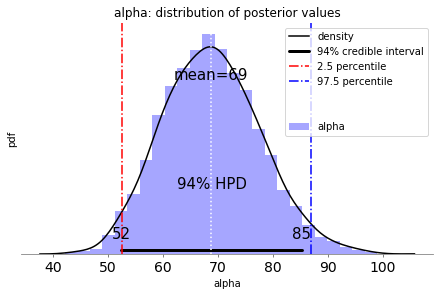

In [70]:
# compute 95% confidence interval for the mean using Bayesian Inference
bayes_dist, bayes_min, bayes_max = bayesian_mean(us_sample)